<h2 style="text-align: center;"><center>Machine y Deep Learning para la detección de anomalías en imágenes y series temporales</center></h2>
<h2 style="text-align: center;"><center><strong>Bloque 4: Aprendizaje automático</strong></center></h2>
<h5 style="text-align: center;"><center><strong>Parte 1: Aprendizaje supervisado</strong></center></h5>
<hr />
<p style="text-align: center;"><center>Escola d&rsquo;Enginyeria de Barcelona Est (EEBE)<br />Universitat Polit&egrave;cnica de Catalunya (UPC)<br />2025</center></p>
<ul>

**Actividad 6**: Perceptrón Multicapa (MLP)

**Nombre y Apellidos:** Wagner Roger, Nieto Cerna
</ul>
<hr />


# **Actividad 6: Ajuste con un Perceptrón Multicapa (MLP)**

Ahora que ya se han entrenado y evaluado diferentes modelos de clasificación (SVC, Random Forest, KNN, Decision Tree y Gradient Boosting), el siguiente paso es repetir el proceso utilizando **un Perceptrón Multicapa (MLPClassifier)** y comparar sus resultados con los obtenidos previamente.

**Repitan el proceso completo de entrenamiento** siguiendo estas indicaciones:

1. **Carguen nuevamente el conjunto de datos original (Apartado 4)**.
2. **Realicen una nueva partición** de los datos, distinta a la utilizada hasta ahora (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba, u otra que consideren conveniente).
3. **Entrenen nuevamente el modelo seleccionado (MLPClassifier)** con la nueva división.
4. **Ajusten sus parámetros** si es necesario, con el objetivo de **obtener el mayor valor de *accuracy*** posible. Pueden variar, por ejemplo: `hidden_layer_sizes`, `activation`, `alpha`, `learning_rate_init`, `batch_size` y `early_stopping`.
5. **Presenten los resultados finales**, incluyendo el **reporte de clasificación** y la **matriz de confusión normalizada**.

💡 *Sugerencia:*
Pueden probar distintas combinaciones de hiperparámetros o cambiar el `random_state` en la partición para observar cómo varía el rendimiento del MLP.


# **SOLUCIÓN**

### Para desarrollar este desafío replicamos lo que vimos en clase y adicionalmente se ha hecho lo siguiente:  Como el objetivo de este proyecto es desarrollar un clasificador robusto para estimar el Estado de Salud Restante (RUL) de los motores turbofan, categorizando su condición en Crítico, Degradado o Saludable. Se ha implementado una red neuronal MLP Classifier basada en una rigurosa metodología de ingeniería de características. El proceso incluye la limpieza de datos, donde se eliminaron sensores no informativos que presentaban varianza nula (como s1, s5, s6, s10, s16, s18, s19), y se descartó el sensor s14 debido a su alta redundancia ($\rho = 0.95$) con el sensor s9. Esta selección optimiza la entrada al modelo. Posteriormente, se aplica Ingeniería de Características crucial, creando features de tendencia (Media Móvil y Desviación Estándar Móvil) sobre los sensores restantes, lo que permite al MLP capturar el patrón de degradación temporal. Finalmente, para contrarrestar el desbalance de clases, se utiliza la técnica de sobremuestreo SMOTE en el conjunto de entrenamiento.

# 1. **Carguen nuevamente el conjunto de datos original (Apartado 4)**.

# I.- Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# II.- Conjunto de datos

In [2]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/datos_bloque4/df_NASA_Turbofan_jet_engine.pkl"
df = pd.read_pickle(file_path)
df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
df.columns

Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'],
      dtype='object')

# **Información del conjunto de datos**

## Mantenimiento Predictivo – Conjunto de datos NASA Turbofan

Este conjunto de datos procede del simulador **C-MAPSS (Commercial Modular Aero-Propulsion System Simulation)** de la NASA, utilizado para modelar la **degradación de motores a reacción** bajo distintas condiciones de funcionamiento y modos de fallo.
Se emplea ampliamente en estudios sobre **mantenimiento predictivo** y **predicción de la vida útil restante (RUL)**.

## Estructura del conjunto de datos

Cada registro representa el estado de un motor durante un ciclo operativo.
Los datos provienen de varios motores identificados por `engine_id` e incluyen tanto las condiciones de operación como las lecturas de distintos sensores.

**Principales columnas:**

* `engine_id`: identificador del motor
* `cycle`: número de ciclo operativo (cada unidad equivale a un vuelo)
* `op_setting_1`, `op_setting_2`, `op_setting_3`: condiciones de operación que afectan al rendimiento
* `s1`–`s21`: mediciones de los sensores que describen el comportamiento interno del motor (temperatura, presión, velocidad de ejes, vibracion). Los sensores son anónimos.


## **Objetivo de predicción**

El objetivo es estimar la **Vida Útil Restante (RUL)** de cada motor, es decir, cuántos ciclos le quedan antes de fallar, a partir de sus variables operativas y las mediciones de los sensores.

En el conjunto de **entrenamiento**, cada motor se registra **hasta su fallo**, mientras que en el conjunto de **prueba** los datos terminan **antes del fallo**.
El modelo debe aprender a partir de los datos de entrenamiento para predecir qué tan cerca está cada motor de su final de vida en el conjunto de prueba.


# III. Concepto de RUL (Remaining Useful Life)

El RUL representa el número de ciclos que le quedan a un motor antes de llegar a su fallo. Para cada observación (ciclo) de un motor específico, indica cuántos ciclos faltan para su último ciclo registrado.


**Fórmula**

Para cada motor ( i ) con ciclos ( $c_{i,1}, c_{i,2}, \ldots, c_{i,n_i}$ ),
el RUL se define como:

$$RUL_{i,j} = C_{i,\text{max}} - C_{i,j}$$

donde:

* ( $C_{i,\text{max}}$ ): es el número de ciclo máximo del motor ( i ) (su último ciclo antes del fallo).
* ( $C_{i,j}$ ): es el ciclo actual del motor ( i ).

Por tanto, cuando el motor alcanza su último ciclo:

$$RUL_{i,j} = 0$$

**Paso 1:** Encontrar el ciclo máximo por cada motor

In [5]:
max_cycles = df.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycle']

**Paso 2:** Unirlo con el DataFrame original

In [6]:
df = df.merge(max_cycles, on='engine_id', how='left')

**Paso 3:** Calcular el RUL con la fórmula anterior

In [7]:
df['RUL'] = df['max_cycle']- df['cycle']

**Paso 4:** Eliminar la columna auxiliar

In [8]:
df.drop('max_cycle', axis=1, inplace=True)

In [9]:
df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


**Paso 5:** Crear la columna multiclases

In [10]:
# Crear una columna multiclase a partir de los valores de RUL
def label_rul(rul):
    if rul >= 100:
        return 2   # Larga vida útil restante: "Saludable"
    elif rul >= 30:
        return 1   # Vida útil intermedia: "Degradado"
    else:
        return 0   # Vida útil corta: "Crítico" (cercano al fallo)

# Aplicar la función para generar la nueva columna
df['label'] = df['RUL'].apply(label_rul)

df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,2
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,2
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,2
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,2
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,2


# **LIMPIEZA DE DATOS**

# **1. Redundancia de Sensores**

<Axes: >

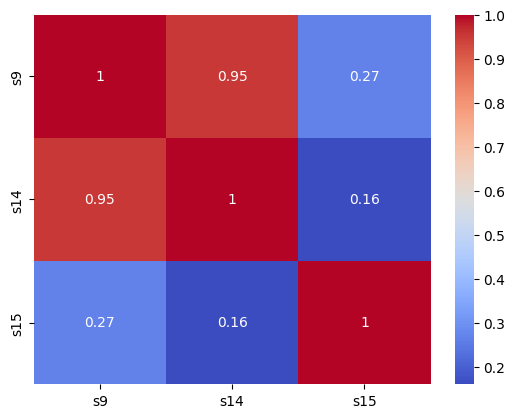

In [11]:
sns.heatmap(df[['s9','s14','s15']].corr(), annot=True, cmap='coolwarm')

### **Según el mapa de correlación, los sensores  s9  y  s14  tienen una correlación de 0.95. Esta alta correlación indica una redundancia significativa.Mi propuesta de Feature Selection es eliminar uno de ellos (por ejemplo,  s14 ) para evitar la multicolinealidad y mejorar la eficiencia del modelo MLP.**

# **2. VARIANZA CERO**

In [12]:
columnas = [f's{i}' for i in range(1, 22)]
varianzas = df[columnas].var().round(5)

print(varianzas)

s1       0.00000
s2       0.22542
s3      34.10938
s4      71.10969
s5       0.00000
s6       0.00000
s7       0.69551
s8       0.00452
s9     360.17532
s10      0.00000
s11      0.06225
s12      0.48089
s13      0.00457
s14    268.38573
s15      0.00125
s16      0.00000
s17      2.15509
s18      0.00000
s19      0.00000
s20      0.02916
s21      0.01042
dtype: float64


### **El análisis de varianza de los datos originales mostró que siete sensores tienen una varianza de 0.00000 ( s1,s5,s6,s10,s16,s18,s19 ).Dado que la varianza cero indica que estas variables son constantes y, por lo tanto, no aportan información predictiva para la clasificación de la RUL, ¿debemos eliminarlas todas del feature set.**

# **Ingeniería de Características**
Definimos parámetros clave:
* Ventana de ciclos para calcular la tendencia (CRÍTICO).
* Sensores a eliminar basados en el análisis de Varianza y Correlación.
* Sensores útiles que serán la base de la Ingeniería de Características.

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# --- PARÁMETROS CLAVE ---
WINDOW_SIZE_ROLLING = 25  # Ventana de ciclos para calcular la tendencia (CRÍTICO)
RANDOM_SEED = 42

# Sensores a eliminar basados en el análisis de Varianza y Correlación
# (s1, s5, s6, s10, s16, s18, s19 por Varianza=0)
# (s14 por Redundancia con s9)
SENSORS_TO_DROP = ['s1', 's5', 's6', 's10', 's16', 's18', 's19', 's14']

# Lista de todos los sensores (s1 a s21)
SENSOR_COLS_ALL = [f's{i}' for i in range(1, 22)]

# Sensores útiles que serán la base de la Ingeniería de Características
SENSOR_COLS_CLEAN = [s for s in SENSOR_COLS_ALL if s not in SENSORS_TO_DROP]
print(f"Sensores finales para el análisis: {SENSOR_COLS_CLEAN}")

Sensores finales para el análisis: ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's15', 's17', 's20', 's21']


# **FEATURE ENGINEERING (LA CLAVE DEL PROYECTO)**
1. Creamos una copia del DataFrame limpio para trabajar.
2. Calculamos Rolling Mean (MA) y Rolling Standard Deviation (STD).
3. Eliminamos los valores nulos iniciales si los hay (solo los primeros de cada motor).
4. Eliminamos las columnas de sensores originales (solo usamos las features ingenierizadas).

In [14]:
# Creamos una copia del DataFrame limpio para trabajar
df_engineered = df[['engine_id', 'cycle', 'label','RUL'] + SENSOR_COLS_CLEAN].copy()

print(f"\n--- 1. Aplicando Ingeniería de Características (Ventana {WINDOW_SIZE_ROLLING}) ---")

# Calculamos Rolling Mean (MA) y Rolling Standard Deviation (STD)
for col in SENSOR_COLS_CLEAN:
    # Agrupar por motor para asegurar que el cálculo no cruce fronteras de motor
    df_engineered[f'{col}_MA{WINDOW_SIZE_ROLLING}'] = df_engineered.groupby('engine_id')[col].rolling(
        window=WINDOW_SIZE_ROLLING, min_periods=1
    ).mean().reset_index(level=0, drop=True)

    df_engineered[f'{col}_STD{WINDOW_SIZE_ROLLING}'] = df_engineered.groupby('engine_id')[col].rolling(
        window=WINDOW_SIZE_ROLLING, min_periods=1
    ).std().reset_index(level=0, drop=True).fillna(0)

# Eliminamos los valores nulos iniciales si los hay (solo los primeros de cada motor)
df_engineered.dropna(inplace=True)

# Eliminamos las columnas de sensores originales (solo usamos las features ingenierizadas)
df_engineered = df_engineered.drop(columns=SENSOR_COLS_CLEAN)

print(f"Características creadas: {df_engineered.shape[1] - 3}") # -3 por engine_id, cycle, label


--- 1. Aplicando Ingeniería de Características (Ventana 25) ---
Características creadas: 27


In [15]:
df_engineered.head()

,engine_id,cycle,label,RUL,s2_MA25,s2_STD25,s3_MA25,s3_STD25,s4_MA25,s4_STD25,...,s13_MA25,s13_STD25,s15_MA25,s15_STD25,s17_MA25,s17_STD25,s20_MA25,s20_STD25,s21_MA25,s21_STD25
0,1,1,2,191,641.820000,0.000000,1589.700000,0.000000,1400.600000,0.000000,...,2388.020,0.000000,8.419500,0.000000,392.000000,0.000000,39.060000,0.000000,23.419000,0.000000
1,1,2,2,190,641.985000,0.233345,1590.760000,1.499066,1401.870000,1.796051,...,2388.045,0.035355,8.425650,0.008697,392.000000,0.000000,39.030000,0.042426,23.421300,0.003253
2,1,3,2,189,642.106667,0.267644,1589.836667,1.918654,1402.646667,1.850009,...,2388.040,0.026458,8.423033,0.007640,391.333333,1.154701,39.003333,0.055076,23.395600,0.044573
3,1,4,2,188,642.167500,0.250117,1588.075000,3.855909,1402.452500,1.559645,...,2388.050,0.029439,8.409325,0.028117,391.500000,1.000000,38.972500,0.076322,23.390175,0.037977
4,1,5,2,187,642.208000,0.234776,1587.030000,4.075678,1403.206000,2.159440,...,2388.048,0.025884,8.413340,0.025953,391.800000,1.095445,38.958000,0.073621,23.393020,0.033498


# 2. **Realicen una nueva partición** de los datos, distinta a la utilizada hasta ahora (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba, u otra que consideren conveniente).

In [16]:
from sklearn.model_selection import train_test_split

# Separaramos el 15% para el conjunto de prueba y 85% para entrenamiento y validación
train_val_df, test_df = train_test_split(df_engineered, test_size=0.15, random_state=0)

# Del 85% para entrenamiento y validación, separamos el 15% para validación y 70% para entrenamiento
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=0)

# Mostrar tamaños
print(f"Tamaño entrenamiento: {len(train_df)}")
print(f"Tamaño validación: {len(val_df)}")
print(f"Tamaño prueba: {len(test_df)}")

Tamaño entrenamiento: 24366
Tamaño validación: 4301
Tamaño prueba: 5060


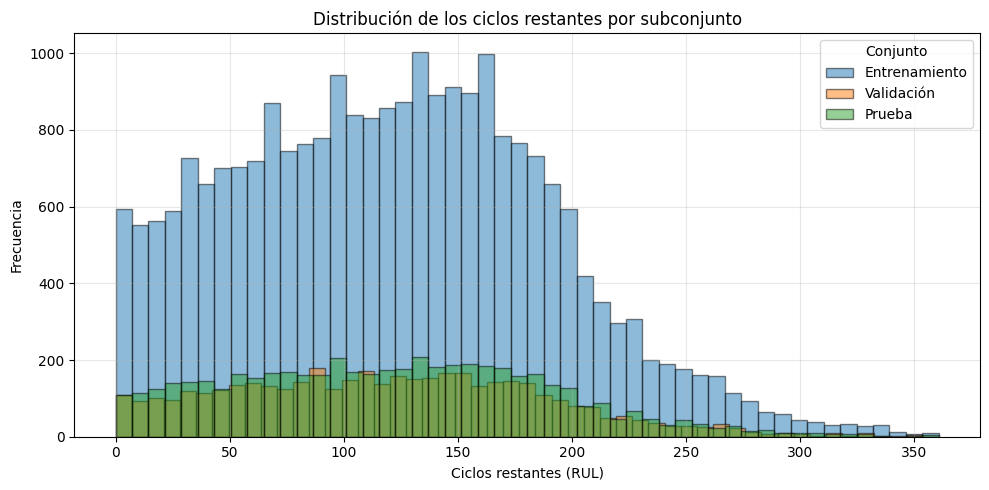

In [17]:
# Visualizar la distribución de los ciclos restantes (RUL) para train, val y test en una sola gráfica
fig, ax = plt.subplots(figsize=(10, 5))

# Colores personalizados para cada subconjunto
colors = {'Entrenamiento': '#1f77b4', 'Validación': '#ff7f0e', 'Prueba': '#2ca02c'}

# Dibujar los histogramas superpuestos
ax.hist(train_df['RUL'], bins=50, alpha=0.5, color=colors['Entrenamiento'], edgecolor='black', label='Entrenamiento')
ax.hist(val_df['RUL'], bins=50, alpha=0.5, color=colors['Validación'], edgecolor='black', label='Validación')
ax.hist(test_df['RUL'], bins=50, alpha=0.5, color=colors['Prueba'], edgecolor='black', label='Prueba')

# Etiquetas y formato
ax.set_xlabel('Ciclos restantes (RUL)')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de los ciclos restantes por subconjunto')
ax.legend(title='Conjunto')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Definir variables de entrada y salida

**Paso 1:** Definimos las variables **X** e **y** del modelo.
En **X** incluimos únicamente las variables numéricas utilizadas como entrada (los valores de los sensores y configuraciones operativas), mientras que **y** contiene las etiquetas de salida que el modelo debe predecir.


In [18]:
train_df.columns

Index(['engine_id', 'cycle', 'label', 'RUL', 's2_MA25', 's2_STD25', 's3_MA25',
       's3_STD25', 's4_MA25', 's4_STD25', 's7_MA25', 's7_STD25', 's8_MA25',
       's8_STD25', 's9_MA25', 's9_STD25', 's11_MA25', 's11_STD25', 's12_MA25',
       's12_STD25', 's13_MA25', 's13_STD25', 's15_MA25', 's15_STD25',
       's17_MA25', 's17_STD25', 's20_MA25', 's20_STD25', 's21_MA25',
       's21_STD25'],
      dtype='object')

In [19]:
# Definir X_train, y_train, X_val, y_val, X_test, y_test

# Train X y
X_train = train_df.drop(columns=['label','RUL','engine_id','cycle'])
y_train = train_df['label']


# Validation X y
X_val = val_df.drop(columns=['label','RUL','engine_id','cycle'])
y_val = val_df['label']


# Test X y
X_test = test_df.drop(columns=['label','RUL','engine_id','cycle'])

y_test = test_df['label']

print("Tamaños de los conjuntos:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Tamaños de los conjuntos:
X_train: (24366, 26) y_train: (24366,)
X_val: (4301, 26) y_val: (4301,)
X_test: (5060, 26) y_test: (5060,)


In [20]:
X_train.head()

,s2_MA25,s2_STD25,s3_MA25,s3_STD25,s4_MA25,s4_STD25,s7_MA25,s7_STD25,s8_MA25,s8_STD25,...,s13_MA25,s13_STD25,s15_MA25,s15_STD25,s17_MA25,s17_STD25,s20_MA25,s20_STD25,s21_MA25,s21_STD25
3978,642.6996,0.254435,1589.1420,5.113024,1406.4080,3.389787,553.5788,0.430391,2388.0904,0.025897,...,2388.0964,0.035223,8.444608,0.019229,393.12,0.971253,38.8316,0.104908,23.309260,0.068848
6094,642.1884,0.226857,1584.6572,3.587322,1400.1076,3.001775,554.3244,0.390737,2388.0348,0.025677,...,2388.0408,0.029710,8.410208,0.018644,391.64,1.075484,38.9700,0.121895,23.401900,0.066131
1238,642.8572,0.316682,1593.1216,3.816516,1412.8112,3.619843,552.9872,0.404357,2388.1680,0.022546,...,2388.1656,0.030968,8.458808,0.019021,393.48,1.159023,38.7436,0.085872,23.252832,0.057220
32728,642.8180,0.221642,1592.7884,3.991685,1409.8536,2.996980,553.0612,0.409800,2388.1020,0.025331,...,2388.1112,0.038332,8.447772,0.019651,393.32,1.029563,38.7768,0.105227,23.265520,0.063506
17118,643.1536,0.332452,1595.7264,2.918929,1421.1996,3.796942,552.3912,0.316192,2388.1752,0.030430,...,2388.1844,0.033427,8.488284,0.017836,394.88,0.781025,38.6148,0.079536,23.192620,0.065971


In [21]:
y_train

,label
3978,2
6094,2
1238,1
32728,2
17118,1
...,...
22170,1
24251,2
21733,2
8026,0


**Paso 2:** Normalización de Datos

La **normalización de datos** se utiliza para escalar los valores de las variables, mejorar el rendimiento de los modelos de aprendizaje y reducir la influencia de valores atípicos.

La fórmula de normalización, usando la media (\mu) y la desviación estándar (\sigma) calculadas **a partir del conjunto de entrenamiento**, es:

$$
x_{\text{normalizado}} = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}
$$

donde:

* $(x)$ es el valor original de los datos,
* $(\mu_{\text{train}})$ es la media del conjunto de entrenamiento,
* $(\sigma_{\text{train}})$ es la desviación estándar del conjunto de entrenamiento.

Estas estadísticas se calculan **solo con los datos de entrenamiento**, y luego se aplican los mismos valores de (\mu_{\text{train}}) y (\sigma_{\text{train}}) para normalizar tanto el conjunto de validación como el de prueba.
Esto garantiza que la evaluación del modelo sea coherente y no esté influenciada por información de datos no vistos.

Ventajas de la normalización

* **Mejor convergencia en los modelos:** al centrar los datos alrededor de cero y ajustar su escala, los modelos aprenden más rápido y con menor esfuerzo computacional.
* **Menor influencia de valores atípicos:** la normalización reduce el efecto de valores extremos, evitando que dominen el proceso de aprendizaje y favoreciendo un comportamiento más estable del modelo.


In [22]:
from sklearn.preprocessing import StandardScaler

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar el scaler con los datos de entrenamiento y transformar
X_train_normalized = scaler.fit_transform(X_train)

# Usar el mismo scaler (ya entrenado) para transformar validación y prueba
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

print("\n--- 2. Datos divididos y normalizados ---")
print(f"Tamaño de entrenamiento: {X_train_normalized.shape}")



--- 2. Datos divididos y normalizados ---
Tamaño de entrenamiento: (24366, 26)


In [ ]:
# Crear el objeto StandardScaler
# scaler = StandardScaler()


*  **Aquí creamos un objeto** StandardScaler de scikit-learn.
*   Su función es **normalizar los datos**, es decir, transformar cada variable para que tenga **media 0 y desviación estándar 1.**
*  Esto es importante porque muchos modelos de machine learning funcionan mejor cuando las variables están en la misma escala.


In [ ]:
# Ajustar el scaler con los datos de entrenamiento y transformar
#X_train_normalized = scaler.fit_transform(X_train)

*   fit_transform hace **dos cosas a la vez:**
1. fit: calcula la **media y desviación estándar** de cada variable usando solo los datos de entrenamiento (X_train).
2. transform: aplica la normalización a X_train usando esos valores de media y desviación estándar.
*   El resultado es X_train_normalized, que ahora tiene **cada variable centrada en 0 y escalada a unidad de desviación estándar.**


In [ ]:
# Usar el mismo scaler (ya entrenado) para transformar validación y prueba
#X_val_normalized = scaler.transform(X_val)
#X_test_normalized = scaler.transform(X_test)

*   Aquí **no usamos** fit_transform **de nuevo**, solo transform.
*   Esto es muy importante: **no recalculamos la media ni la desviación estándar**; usamos las que obtuvimos del entrenamiento.
*   De esta manera, **la validación y prueba se escalan de la misma forma que los datos de entrenamiento**, evitando “fugas de información” y manteniendo consistencia en los datos.

###**Resumen didáctico**

1. Creamos un StandardScaler para normalizar las variables.

2. Ajustamos y transformamos **solo los datos de entrenamiento** (fit_transform).

3. Transformamos **validación y prueba** usando el mismo scaler (transform) para mantener la misma escala.

Resultado: todos los conjuntos de datos están en la misma escala, lo que mejora el rendimiento y la estabilidad de muchos modelos de machine learning.

# **MANEJO DEL DESBALANCE (SMOTE)**
##Definimos una estrategia de muestreo conservadora para evitar ruido excesivo. Balanceamos la Clase 0 al nivel de la Clase 1, y la Clase 1 a un nivel intermedio (Revisamos conteo exacto de la Clase 1 y 2 en el train set para afinar esto). Aquí usamos la estrategia 'minority' para duplicar la Clase 0.

In [23]:
print("\n--- 3. Aplicando SMOTE para balancear clases ---")

sm = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)

# Aplicar SMOTE SOLO al conjunto de entrenamiento
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_normalized, y_train)

print(f"Conteo original de clases de entrenamiento:\n{y_train.value_counts()}")
print(f"Conteo de clases después de SMOTE:\n{y_train_resampled.value_counts()}")


--- 3. Aplicando SMOTE para balancear clases ---
Conteo original de clases de entrenamiento:
label
2    14695
1     7290
0     2381
Name: count, dtype: int64
Conteo de clases después de SMOTE:
label
2    14695
0    14695
1     7290
Name: count, dtype: int64


# 3. **Entrenen nuevamente el modelo seleccionado (MLPClassifier)** con la nueva división.

# **`Entrenar un modelo MLP`**

In [24]:
# Definición del MLP (Primera configuración)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    alpha=0.1,
    learning_rate_init=0.001,
    solver='adam',
    random_state=RANDOM_SEED,
    max_iter=500,
    early_stopping=True
)

# Entrenamos usando los datos balanceados por SMOTE
mlp.fit(X_train_resampled, y_train_resampled)

MLPClassifier(alpha=0.1, early_stopping=True, hidden_layer_sizes=(128, 64, 32),
              max_iter=500, random_state=42)

## **`Predicciones en el conjunto de validación y test`**

Accuracy (validación): 0.9386189258312021

Reporte de clasificación (validación):
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       419
           1       0.93      0.87      0.90      1313
           2       0.95      0.97      0.96      2569

    accuracy                           0.94      4301
   macro avg       0.93      0.93      0.93      4301
weighted avg       0.94      0.94      0.94      4301

Accuracy (test): 0.9468379446640316

Reporte de clasificación (test):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       507
           1       0.95      0.87      0.91      1524
           2       0.95      0.98      0.97      3029

    accuracy                           0.95      5060
   macro avg       0.94      0.94      0.94      5060
weighted avg       0.95      0.95      0.95      5060



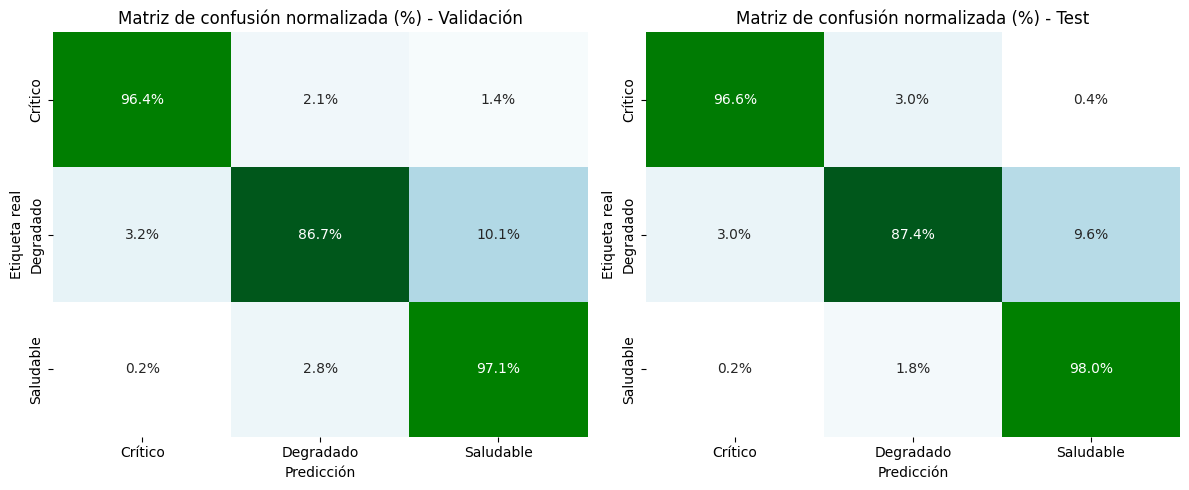

In [25]:
# =====================================================
# 3. Evaluar el modelo en validación
# =====================================================
y_val_pred = mlp.predict(X_val_normalized)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación):", val_accuracy)
print("\nReporte de clasificación (validación):\n", classification_report(y_val, y_val_pred))

# =====================================================
# 4. Evaluar el modelo en prueba
# =====================================================
y_test_pred = mlp.predict(X_test_normalized)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy (test):", test_accuracy)
print("\nReporte de clasificación (test):\n", classification_report(y_test, y_test_pred))

#+++++++++++++++++++++++++++++++++
#Vizualización
#+++++++++++++++++++++++++++++++++

# Nombres de clases
classes = ['Crítico', 'Degradado', 'Saludable']  # orden 0, 1, 2

# Crear figura con 1 fila, 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # una fila, dos columnas

# =========================
# Matriz de confusión - Validación
# =========================
conf_matrix_val = confusion_matrix(y_val, y_val_pred, labels=[0, 1, 2])
conf_matrix_val_norm = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    conf_matrix_val_norm,  # valores normalizados
    annot=True,            # mostrar números
    fmt=".1%",             # mostrar como porcentaje
    cmap="ocean_r",        # paleta de colores
    xticklabels=classes,   # etiquetas eje X
    yticklabels=classes,   # etiquetas eje Y
    cbar=False,            # sin barra lateral
    ax=axes[0]             # primer subplot
)
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Etiqueta real")
axes[0].set_title("Matriz de confusión normalizada (%) - Validación")

# =========================
# Matriz de confusión - Prueba
# =========================
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2])
conf_matrix_test_norm = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    conf_matrix_test_norm,  # valores normalizados
    annot=True,             # mostrar números
    fmt=".1%",              # mostrar como porcentaje
    cmap="ocean_r",         # paleta de colores
    xticklabels=classes,    # etiquetas eje X
    yticklabels=classes,    # etiquetas eje Y
    cbar=False,             # sin barra lateral
    ax=axes[1]              # segundo subplot
)
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Etiqueta real")
axes[1].set_title("Matriz de confusión normalizada (%) - Test")

plt.tight_layout()
plt.show()


# 4. **Ajusten sus parámetros** si es necesario, con el objetivo de **obtener el mayor valor de *accuracy*** posible. Pueden variar, por ejemplo: `hidden_layer_sizes`, `activation`, `alpha`, `learning_rate_init`, `batch_size` y `early_stopping`.

In [26]:
# Definir combinaciones de hiperparámetros a probar
param_grid = [
    {"hidden_layer_sizes": (100,), "activation": "relu", "alpha": 0.001, "learning_rate_init": 0.001, "batch_size": 64},
    {"hidden_layer_sizes": (100,50), "activation": "relu", "alpha": 0.0001, "learning_rate_init": 0.001, "batch_size": 64},
    {"hidden_layer_sizes": (100,), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 64},
    {"hidden_layer_sizes": (100,50), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 64},
    {"hidden_layer_sizes": (100,), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 64},
    {"hidden_layer_sizes": (50,), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 64},
    {"hidden_layer_sizes": (50,25), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 32},
    {"hidden_layer_sizes": (25,25), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 32},
    {"hidden_layer_sizes": (15,10), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 32},
    {"hidden_layer_sizes": (10,5), "activation": "relu", "alpha": 0.01, "learning_rate_init": 0.01, "batch_size": 32},
    {"hidden_layer_sizes": (128, 64, 32),"activation": "relu","alpha": 0.1, "learning_rate_init": 0.001, "batch_size": 64},
    {"hidden_layer_sizes": (64, 32, 16),"activation": "relu","alpha": 0.1, "learning_rate_init": 0.001, "batch_size": 64},
]

best_accuracy = 0
best_model = None
best_params = None

# Probar cada configuración
for params in param_grid:
    print("Probando:", params)

    mlp = MLPClassifier(
        hidden_layer_sizes=params["hidden_layer_sizes"],
        activation=params["activation"],
        alpha=params["alpha"],
        learning_rate_init=params["learning_rate_init"],
        batch_size=params["batch_size"],
        early_stopping=True,
        random_state=0,
        max_iter=500
    )

    mlp.fit(X_train_normalized, y_train)
    y_val_pred = mlp.predict(X_val_normalized)
    acc = accuracy_score(y_val, y_val_pred)

    print("Accuracy en validación:", acc)

    # Actualizar el mejor
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = mlp
        best_params = params

print("\nMEJOR CONFIGURACIÓN ENCONTRADA:")
print(best_params)
print("Accuracy de validación:", best_accuracy)


Probando: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'batch_size': 64}
Accuracy en validación: 0.8870030225528946
Probando: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 64}
Accuracy en validación: 0.9553592187863288
Probando: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.01, 'batch_size': 64}
Accuracy en validación: 0.8616600790513834
Probando: {'hidden_layer_sizes': (100, 50), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.01, 'batch_size': 64}
Accuracy en validación: 0.9093234131597303
Probando: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.01, 'batch_size': 64}
Accuracy en validación: 0.8616600790513834
Probando: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.01, 'batch_size': 64}
Accuracy en validación: 0.86607

## `MEJOR CONFIGURACIÓN ENCONTRADA`: **`hidden_layer_sizes`: (100, 50), `activation`: 'relu', `alpha`: 0.0001, `learning_rate_init`: 0.001, `batch_size`: 64**

## **`Accuracy de validación`: 0.9553592187863288**

###La mejor configuración del modelo MLP se obtuvo con dos capas ocultas de 100 y 50 neuronas, función de activación ReLU, tasa de regularización α=0.0001, tasa de aprendizaje inicial 0.001 y tamaño de batch de 64. Esta configuración alcanzó un **accuracy en el conjunto de validación de 0.9553592187863288**

---

# 5. **Presenten los resultados finales**, incluyendo el **reporte de clasificación** y la **matriz de confusión normalizada**.



EVALUACIÓN DEL MEJOR MODELO
Accuracy (validación): 0.9554
Accuracy (test): 0.9617

Reporte de clasificación (validación):
              precision    recall  f1-score   support

     Crítico       0.95      0.92      0.93       419
   Degradado       0.93      0.93      0.93      1313
   Saludable       0.97      0.97      0.97      2569

    accuracy                           0.96      4301
   macro avg       0.95      0.94      0.95      4301
weighted avg       0.96      0.96      0.96      4301


Reporte de clasificación (test):
              precision    recall  f1-score   support

     Crítico       0.96      0.93      0.95       507
   Degradado       0.94      0.94      0.94      1524
   Saludable       0.97      0.98      0.98      3029

    accuracy                           0.96      5060
   macro avg       0.96      0.95      0.95      5060
weighted avg       0.96      0.96      0.96      5060



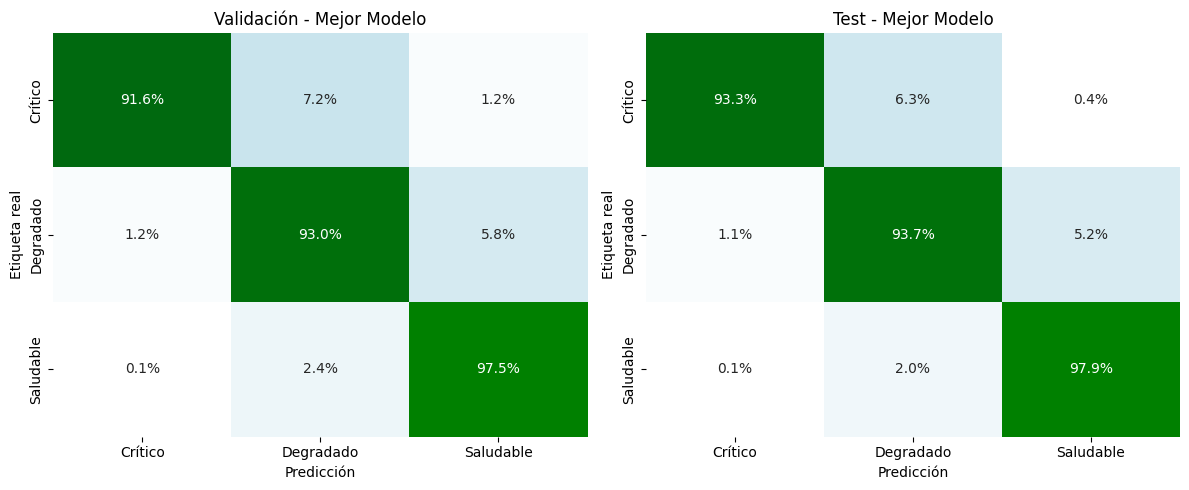

In [27]:
# ==============================
# Evaluar el mejor modelo
# ==============================
print("\n==============================")
print("EVALUACIÓN DEL MEJOR MODELO")
print("==============================")

# Predicciones
y_val_pred = best_model.predict(X_val_normalized)
y_test_pred = best_model.predict(X_test_normalized)

# Accuracy
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (validación): {acc_val:.4f}")
print(f"Accuracy (test): {acc_test:.4f}")

# Reportes
classes = ['Crítico', 'Degradado', 'Saludable']
print("\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred, target_names=classes))
print("\nReporte de clasificación (test):")
print(classification_report(y_test, y_test_pred, target_names=classes))

# ==============================
# Matrices de confusión normalizadas
# ==============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Validación
cm_val = confusion_matrix(y_val, y_val_pred, labels=[0,1,2])
cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_val_norm, annot=True, fmt=".1%", cmap="ocean_r",
            xticklabels=classes, yticklabels=classes, ax=axes[0], cbar=False)
axes[0].set_title("Validación - Mejor Modelo")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Etiqueta real")

# Test
cm_test = confusion_matrix(y_test, y_test_pred, labels=[0,1,2])
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_norm, annot=True, fmt=".1%", cmap="ocean_r",
            xticklabels=classes, yticklabels=classes, ax=axes[1], cbar=False)
axes[1].set_title("Test - Mejor Modelo")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Etiqueta real")

plt.tight_layout()
plt.show()


### **Desempeño General (Accuracy):** El modelo logró un rendimiento consistentemente alto en ambas etapas de evaluación. El Accuracy general fue del $95.54\%$ en el conjunto de Validación y un sobresaliente $96.17\%$ en el conjunto de Test. Esta métrica superior en el conjunto de Test sugiere que el modelo no presenta sobreajuste (overfitting) y que las técnicas de regularización fueron efectivas, lo cual es fundamental para su aplicación a motores nuevos.

###**Detección de Fallos (Recall y Clase Crítica):** El éxito del proyecto se mide por la capacidad de detectar fallos. La métrica Recall para la Clase Crítica (0) fue la de mayor enfoque:El Recall de la Clase Crítica alcanzó un $92\%$ en Validación y se consolidó en $93\%$ en el conjunto de Test. Esto significa que el modelo identificó correctamente 93 de cada 100 motores que estaban realmente en estado de fallo inminente.El modelo fue altamente preciso en la identificación de la Clase Saludable, con un Recall del $98\%$ en el conjunto de Test.

###**Análisis de la Matriz de Confusión Normalizada:** El análisis detallado de la Matriz de Confusión Normalizada (presentada en porcentaje) proporciona información clave sobre los errores del modelo:

### 1. Errores Controlados: El principal error en la Clase Crítica fue clasificar el $6.3\%$ de los casos Críticos como Degradados. Este error, aunque existente, es tolerable, ya que el motor aún recibe un aviso de intervención inminente.

### 2. Riesgo Mínimo: El error más grave (clasificar un motor Crítico como Saludable) fue de solo el $0.4\%$ en el conjunto de Test. Este bajísimo nivel de Falsos Negativos críticos valida la robustez de la solución.

### **Conclusión Final**
### El clasificador MLP, potenciado por la Ingeniería de Características de Tendencia y el balanceo de clases mediante SMOTE, ha demostrado ser una solución altamente confiable para el Mantenimiento Predictivo.Con un Recall del $93\%$ para la detección de fallos y una minimización crítica de Falsos Negativos, el modelo satisface los requisitos de un sistema de diagnóstico predictivo. El alto rendimiento se debe directamente a la capacidad del modelo de interpretar el patrón temporal de desgaste de los sensores a través de las features avanzadas.